In [27]:
import random
import math
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [28]:
# Dimension number (number of the attributes)
DIM_SIZE = 30
# The above values are the benchmark function dependent
MIN_VALUES = -500.0
MAX_VALUES = 500.0


In [29]:
#Create type for minimization of the function
creator.create("FitnessMin",base.Fitness,weights=(-1.0,))

#Create type for store individual (in this example we use list) 
creator.create("Individual", list, fitness=creator.FitnessMin)

C:\Users\Erasmus\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Erasmus\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [30]:
def rand_float_domain(start,stop):
    return random.random()*(stop - start) + start

In [31]:
#Create toolbox for register needed functions
toolbox = base.Toolbox()

#register way of init individuals
#Register function used for init content of the individual (for the benchmark function are the real values)
toolbox.register("attribute_float",rand_float_domain, 
start=MIN_VALUES, stop=MAX_VALUES)

#Register function used for init Population of the individuals
toolbox.register("individual", tools.initRepeat, 
creator.Individual, toolbox.attribute_float, n=DIM_SIZE)

#Register function for create population of individuals
toolbox.register("population",tools.initRepeat, list, 
toolbox.individual)


In [32]:
# The power function (domain <-100,100>)
def F1(tab):
    return sum([x*x for x in tab]),


In [33]:
def F2(tab):
    suma = sum([abs(x) for x in tab])
    mul = 1
    for x in tab:
        mul*= abs(x)
    return suma + mul,

In [34]:
# Definition of the Generalized Schwefel Problem 2.26 (F8) (domain <-500, 500>)
def F8(tab):
    return sum([ math.sin(math.sqrt(abs(x))) for x in tab]),

In [35]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


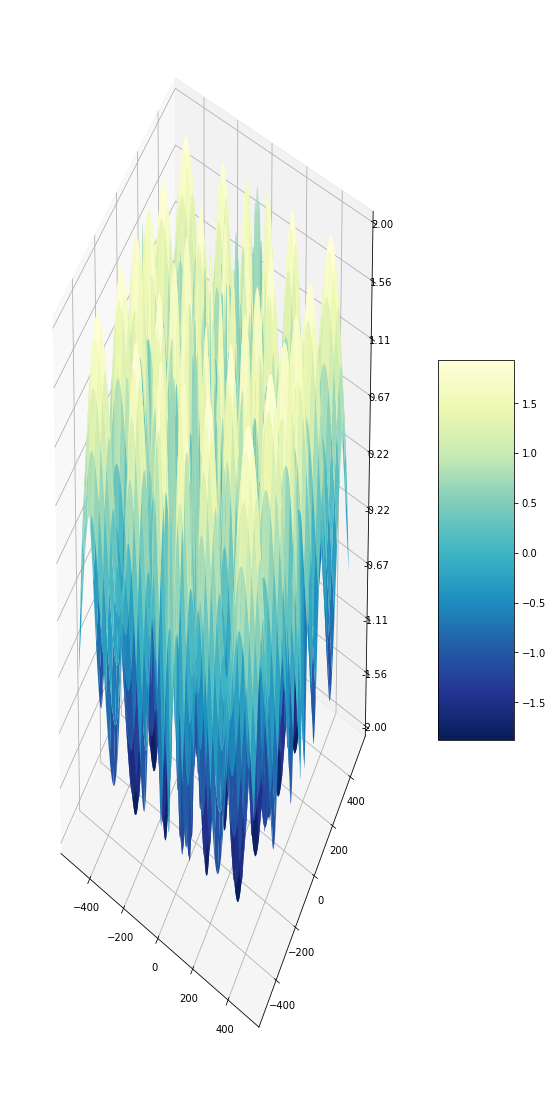

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm, ticker
from matplotlib.ticker import LinearLocator
import numpy as np

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

fig.set_figwidth(20)
fig.set_figheight(20)
MIN_VALUES = -500
MAX_VALUES = 500
steep = 1

# Make data.
X = np.arange(MIN_VALUES, MAX_VALUES, steep)
Y = np.arange(MIN_VALUES, MAX_VALUES, steep)
X, Y = np.meshgrid(X, Y)

zs = np.array([F8([p,k]) for p, k in zip(np.ravel(X),np.ravel(Y))])
Z = zs.reshape(X.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.YlGnBu_r,linewidth=0.1, antialiased=True)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.02f}'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()



In [39]:
toolbox.register("mutate",tools.mutGaussian)
toolbox.register("select",tools.selTournament, tournsize=3)
toolbox.register("evaluate",F8)

In [41]:
import numpy
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg",numpy.mean)
stats.register("std",numpy.std)
stats.register("min",numpy.min)
stats.register("max",numpy.max)


In [52]:
# Evolution Strategy 1 + 1
def ES_ALG(MUTPB,NGEN,POPSIZE,K,ro,stats):
    # Loogs
    logbook = tools.Logbook()
    # ro history changes
    ro_history = []
    #Define the conroll variables
    k = 0 # the actual number of iteration between adaptation
    phi_k_count = 0 # the actual number of success mutation
    c1 = 0.82 # The decrease factor (for ro)
    c2 = 1.2 # The increase factor (for ro)
    
    # Create a population of the solutions
    xs = toolbox.population(n=POPSIZE) #(1)
    # Evaluate the entire population #(2)
    fitnesses = map(toolbox.evaluate, xs)
    for ind, fit in zip(xs, fitnesses):
        ind.fitness.values = fit
    # For NGEN number of generations
    for g in range(NGEN):
        # Create the copy of the population (for mutate)
        # The mutated solution replaces the current one, only if it is 
        # better
        ys = [toolbox.clone(x) for x in xs]

        # Mutate the copy of the population
        for y in ys:
            toolbox.mutate(y,0,ro,MUTPB) 
        #Evaluate the mutated individuals
        fitnesses = map(toolbox.evaluate, ys)
        for ind, fit in zip(ys, fitnesses):
            ind.fitness.values = fit

        # Replace by the best solution 
        for i in range(len(xs)):
            if xs[i].fitness.values > ys[i].fitness.values:
                xs[i] = ys[i] # replace only if better
                phi_k_count +=1 # increase success count
        k+= 1
        # After K*2 number of iteration performs adaptation of the mutation range For F8 function, K = 5
        if k == K * 2:
            # Check the success rate
            phi_k = phi_k_count/(K*2*POPSIZE) 
            if phi_k < 0.2:
                ro = ro * c1 # decrease the mutation range
            if phi_k > 0.2:
                ro = ro * c2 # increase the mutation range
            #reset counters
            phi_k_count = 0
            k = 0
        record = stats.compile(xs)
        logbook.record(gen=g, evals=POPSIZE, **record)
        ro_history.append(ro)
        
    return xs, logbook, ro_history


In [59]:
pop, logbook, ro_history = ES_ALG(0.1,900,30,2,1,stats)
gen, avg, std, Min, Max = logbook.select('gen','avg','std','min','max');

No handles with labels found to put in legend.


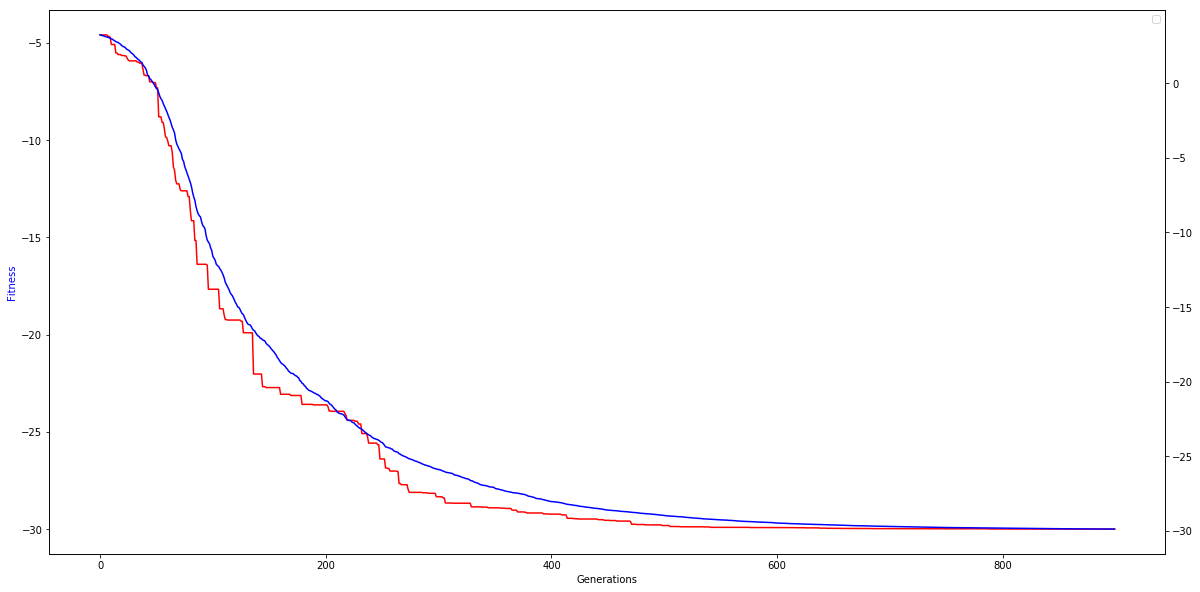

In [60]:
import matplotlib.pyplot as plt
# 1. Change the fitness value of the benchmark function
fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
line1 = ax1.plot(gen, Min, "r-")
ax1.legend()
ax2 = ax1.twinx()
line2 = ax2.plot(gen, avg, "b-")

ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")

plt.show()

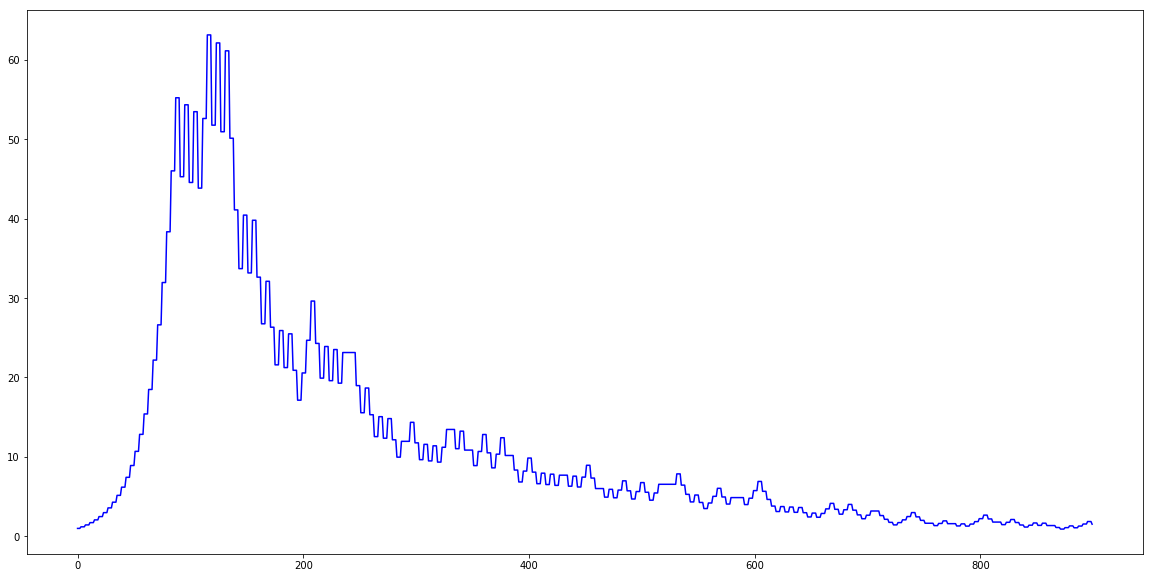

Best is: (-29.99230835283245,)


In [61]:
# Change of the ro parameter (autoadaptation) 
fig2, ax3 = plt.subplots()
fig2.set_figwidth(20)
fig2.set_figheight(10)
line3 = ax3.plot(gen, ro_history, "b-")
plt.show()
fitnes = [ind.fitness.values for ind in pop]
print(f'Best is: {min(fitnes)}')

In [62]:
evaluates = [F8(p) for p in pop]

In [63]:
evaluates

[(-29.992298842642786,),
 (-29.947404337400503,),
 (-29.948731561983998,),
 (-29.985814493823874,),
 (-29.98780397150364,),
 (-29.942663951823913,),
 (-29.985853470284738,),
 (-29.98779669544397,),
 (-29.344576724263803,),
 (-29.984974643243106,),
 (-29.977972033199467,),
 (-29.99230835283245,),
 (-29.921102991130585,),
 (-29.89489721184801,),
 (-29.981534073385326,),
 (-29.980750849664165,),
 (-29.976497704095326,),
 (-29.92628159401275,),
 (-29.883624256214674,),
 (-29.484272584528327,),
 (-29.980404114821756,),
 (-29.543914694516413,),
 (-29.959275234503753,),
 (-29.95439700905382,),
 (-29.966311357663376,),
 (-29.726209131388583,),
 (-29.95336310957724,),
 (-29.97829870989519,),
 (-29.65893797961423,),
 (-29.857784253215595,)]

In [ ]:
#coclusion  in every case we take the parameters MUTPB and K smaller we get better however when we change NGEN opposite bigger , the result would be not the best and not  fast .   
